# Machine Learning 

In [26]:
import os, sys, warnings, json, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', message='.*_validate_data.*')

## 0  Data load

In [3]:
from eda.data_loader import DataLoader  

PROJECT  = 'biking-in-paris'   
DATASET  = 'accidents'
TABLE    = 'fct_accidents_ml'

query = f'SELECT * FROM `{PROJECT}.{DATASET}.{TABLE}` where vehicle_category_cd in (1, 50, 80)'
df = DataLoader(custom_query=query, target_table=TABLE).load_from_bigquery()

print(f'rows={len(df):,}, severe%={df["severity_cd"].isin([2,3]).mean():.1%}')

/Users/zoe/Downloads/safe-biking-in-paris/ml_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading data using custom query...


/Users/zoe/Downloads/safe-biking-in-paris/ml_env/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 28,578 records from BigQuery
rows=28,578, severe%=23.9%


## 1  Feature engineering

In [4]:
# keep original copy
df_copy = df.copy()

In [5]:
# For debugging
df = df_copy.copy()

In [6]:
# Visibility / weather / surface flags
df['low_vis_light']    = df['light_condition_grp_cd'].isin([2,3,4]).astype(int)
df['low_vis_weather']  = df['weather_condition_grp_cd'].isin([2,3,4,5,6,7]).astype(int)
df['bad_surface']      = df['surface_condition_cd'].isin([2,3,4,5,6,7,8]).astype(int)
df['high_speed_multi'] = ((df['speed_limit_kmh']>=70) & (df['number_of_lanes_cd']>1)).astype(int)

In [7]:
# Geo risk (KDE two bandwidths)
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs='EPSG:4326'
).to_crs(2154)  

coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T

def kde_feature(coords_m, bandwidth):
    kde = KernelDensity(bandwidth=bandwidth).fit(coords_m)
    return np.exp(kde.score_samples(coords_m))

for bw in (200, 1000):
    df[f'density_{bw}m'] = kde_feature(coords, bw)

df['geo_risk_score'] = MinMaxScaler().fit_transform(
    np.log1p(df[['density_200m','density_1000m']]).mean(1).values.reshape(-1,1)
)

# binary hotspot (top‑1 %)
cut = np.percentile(df['density_200m'], 99)
df['hotspot_1pct'] = (df['density_200m'] >= cut).astype(int)


In [8]:
# cleanup raw cols
DROP_RAW = [
    'light_condition_grp_cd', 'weather_condition_grp_cd',
    'surface_condition_cd', 'longitude', 'latitude',
    'density_200m', 'density_1000m'
]
df.drop(columns=DROP_RAW, inplace=True)

# label
df['severe'] = df.pop('severity_cd').isin([2, 3]).astype(int)

# drop unused features
df.drop(columns=['hour', 'month', 'age', 'department', 'day_of_week'], inplace=True)

# one-hot encode low-cardinality categoricals
# keep three categories: 1, 50, 80
df = pd.get_dummies(df, columns=['vehicle_category_cd'], drop_first=False)

# clip speed limits to valid range
df['speed_limit_kmh'] = df['speed_limit_kmh'].clip(lower=0, upper=140)

In [9]:
df.head()

,age_group_cd,gender_cd,trip_purpose_cd,has_helmet,within_urban_cd,intersection_type_cd,road_category_cd,public_transport_lane_cd,infrastructure_cd,long_profile_cd,...,low_vis_light,low_vis_weather,bad_surface,high_speed_multi,geo_risk_score,hotspot_1pct,severe,vehicle_category_cd_1,vehicle_category_cd_50,vehicle_category_cd_80
0,5,1,0,0,2,2,4,0,2,1,...,0,0,1,0,0.026119,0,0,True,False,False
1,2,2,1,1,2,2,4,2,-1,1,...,0,1,1,0,0.218079,0,0,True,False,False
2,3,1,0,0,2,1,4,0,0,1,...,0,0,0,0,0.025954,0,0,True,False,False
3,4,1,1,1,2,6,3,0,5,1,...,1,1,1,0,0.000709,0,1,True,False,False
4,3,2,9,0,2,3,4,0,0,1,...,0,0,0,0,0.204832,0,0,False,True,False


## 2  Train / test split

In [10]:
TRAIN_YEARS, TEST_YEAR = [2021,2022], 2023

train_df = df[df['accident_year'].isin(TRAIN_YEARS)]
test_df  = df[df['accident_year']==TEST_YEAR]

X_train, y_train = train_df.drop(columns=['severe','accident_year']), train_df['severe']
X_test , y_test  = test_df .drop(columns=['severe','accident_year']), test_df ['severe']

X_train = X_train.astype('float64')
X_test  = X_test.astype('float64')

print(f'train severe%: {y_train.mean():.3f}  |  test severe%: {y_test.mean():.3f}')

train severe%: 0.249  |  test severe%: 0.226


### Quick diagnostics

In [11]:
print(f'Features: {X_train.shape[1]}')
print('Top feature variances:')
print(X_train.var().sort_values(ascending=False).head())

Features: 36
Top feature variances:
speed_limit_kmh           261.785774
manoeuvre_cd               67.697719
trip_purpose_cd             8.341424
impact_point_cd             8.113731
obstacle_stationary_cd      5.680253
dtype: float64


## 3  Pipeline & hyper‑parameter search

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()

simplified_model = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.85, reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight, random_state=42,
    tree_method='hist', eval_metric='aucpr', verbosity=0
)

simple_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote',   BorderlineSMOTE(sampling_strategy=0.8, random_state=42)),
    ('scaler',  StandardScaler(with_mean=False)),
    ('clf',     simplified_model)
])

param_grid = {
    'smote__sampling_strategy': [0.5, 0.8],
    'clf__max_depth': [4, 6],
    'clf__learning_rate': [0.05, 0.1]
}

fbeta2 = make_scorer(fbeta_score, beta=2)
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(simple_pipeline, param_grid, scoring=fbeta2,
                    cv=tscv, n_jobs=1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print('Best F‑2:', grid.best_score_.round(3))
print('Best params:', grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best F‑2: 0.686
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'smote__sampling_strategy': 0.8}


## 4  Threshold tuning (≥30 % recall)

The model should at least catch 30% severe accidents (true positives).

In [13]:
from sklearn.metrics import precision_recall_curve

def pick_threshold(model, X, y, target_recall=0.30):
    proba = model.predict_proba(X)[:,1]
    p,r,t = precision_recall_curve(y, proba)
    # Skip the first point (r[0]=1.0, trivial "predict everything positive")
    # and look at actual thresholds starting from index 1
    idx = np.where(r[1:] >= target_recall)[0]
    if len(idx):
        # Add 1 back since we sliced from index 1
        return t[idx[0] + 1]
    else:
        return np.percentile(proba, 99)

tscv = TimeSeriesSplit(n_splits=3)
ths = []
for tr_idx, val_idx in tscv.split(X_train):
    m = best_model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
    ths.append(pick_threshold(m, X_train.iloc[val_idx], y_train.iloc[val_idx]))

THRESH = float(np.mean(ths))
print(f'Chosen decision threshold: {THRESH:.4f}')

Chosen decision threshold: 0.0021


## 5. Model Training & evaluation

In [14]:
best_model.fit(X_train, y_train)
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= THRESH).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
print(classification_report(y_test, y_pred, digits=3))
print('ROC‑AUC :', roc_auc_score(y_test, y_proba).round(3))
print('PR‑AUC  :', average_precision_score(y_test, y_proba).round(3))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      1.000     0.000     0.001      9668
           1      0.226     1.000     0.368      2815

    accuracy                          0.226     12483
   macro avg      0.613     0.500     0.184     12483
weighted avg      0.825     0.226     0.083     12483

ROC‑AUC : 0.813
PR‑AUC  : 0.586
Confusion matrix:
 [[   3 9665]
 [   0 2815]]


### PR curve & confusion matrix charts

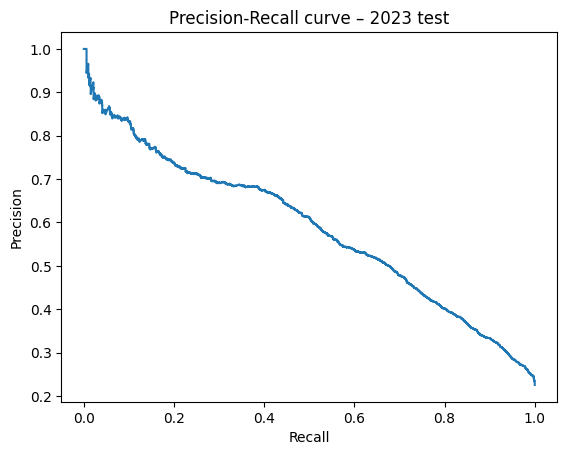

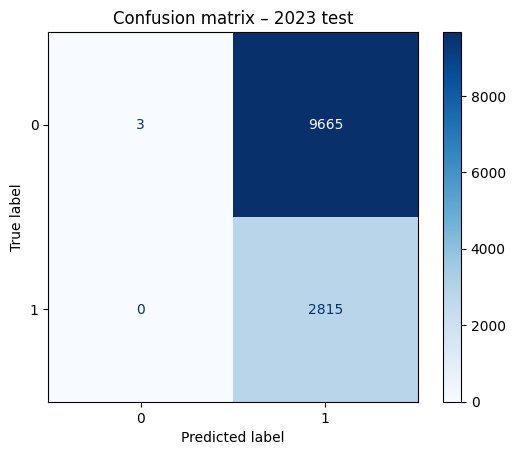

In [16]:

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve

# PR curve
p, r, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(r, p)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision‑Recall curve – 2023 test')
plt.show()

# Confusion matrix plot
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',         
    values_format='d'
)
plt.title('Confusion matrix – 2023 test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Feature Importances

                     feature  importance
0                 has_helmet    0.095466
1             geo_risk_score    0.089853
2                  gender_cd    0.081226
3           road_category_cd    0.074114
4     vehicle_category_cd_50    0.055348
5               age_group_cd    0.050345
6            long_profile_cd    0.047375
7      vehicle_category_cd_1    0.045876
8            within_urban_cd    0.039047
9                bad_surface    0.035120
10                   dow_cos    0.031229
11                is_weekend    0.029454
12                 month_cos    0.028447
13             low_vis_light    0.022908
14  public_transport_lane_cd    0.022051
15        number_of_lanes_cd    0.019139
16                   dow_sin    0.018393
17     time_of_day_bucket_cd    0.018293
18                  hour_sin    0.017593
19           trip_purpose_cd    0.016794


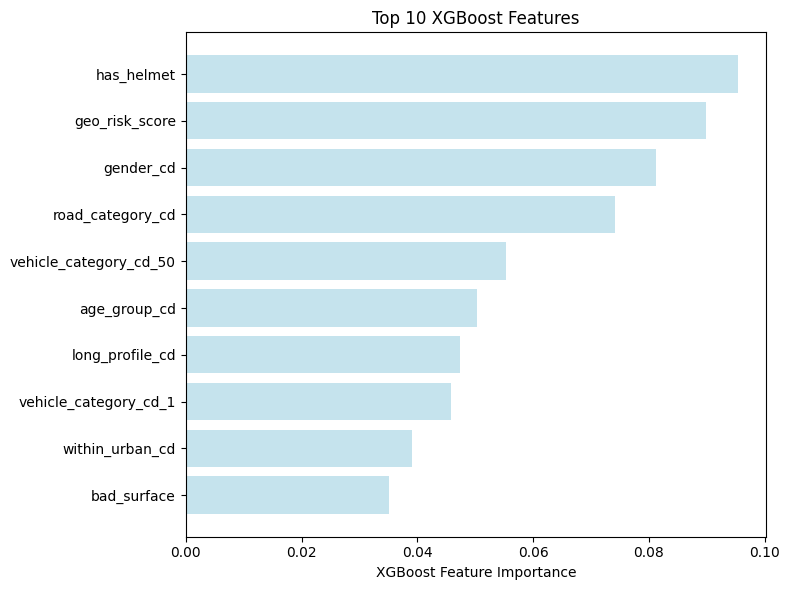

In [35]:
clf = best_model.named_steps["clf"]

importances = clf.feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print(feat_imp.head(20))

# Assuming feat_imp is already sorted descending by "importance"
top_n = 10
top_xgb = feat_imp.head(top_n)

# Plot
plt.figure(figsize=(8, 6))
y_pos = np.arange(top_n)
plt.barh(
    y_pos,
    top_xgb['importance'],
    color='lightblue',
    alpha=0.7
)

# Truncate long names
labels = [
    (f[:20] + '…') if len(f) > 22 else f
    for f in top_xgb['feature']
]
plt.yticks(y_pos, labels)

# Invert so highest importance is at top
plt.gca().invert_yaxis()

plt.xlabel('XGBoost Feature Importance')
plt.title('Top 10 XGBoost Features')
plt.tight_layout()
plt.show()

In [19]:
# Create a pipeline without SMOTE for age group analysis
# (some age groups have too few positive cases)
simple_pipeline_no_smote = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.85, reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight, random_state=42,
        tree_method='hist', eval_metric='aucpr', verbosity=0
    ))
])


## 6. Feature Importance Break Down: Helmet Usage x Age Group

In [ ]:
from sklearn.base import clone
import pandas as pd

Xg = X_train.copy()
Xg["age_group_cd"] = train_df["age_group_cd"]

imp_by_age = {}
expected_features = X_train.columns.tolist()  

for grp in Xg["age_group_cd"].unique():
    mask = Xg["age_group_cd"] == grp
    X_sub = Xg.loc[mask].drop(columns="age_group_cd")
    y_sub = y_train.loc[mask]

    if y_sub.sum() < 10:
        print(f"Skipping age group {grp}: only {y_sub.sum()} severe cases")
        continue

    model_g = clone(simple_pipeline_no_smote)
    model_g.fit(X_sub, y_sub)


    clf_importances = model_g.named_steps["clf"].feature_importances_
    actual_features = X_sub.columns.tolist()
        
    if len(clf_importances) != len(actual_features):
        print(f"Warning: XGBoost dropped {len(actual_features) - len(clf_importances)} features for age group {grp}")
    
    full_importances = np.zeros(len(expected_features))


    if hasattr(model_g.named_steps["clf"], 'feature_names_in_'):
        model_features = model_g.named_steps["clf"].feature_names_in_
    else:
        # Fall back to assuming first N features if XGBoost dropped some
        model_features = actual_features[:len(clf_importances)]
    
    for i, feat in enumerate(model_features):
        if feat in expected_features:
            feat_idx = expected_features.index(feat)
            full_importances[feat_idx] = clf_importances[i]
    
    imp_by_age[grp] = full_importances

imp_df = pd.DataFrame(
    imp_by_age,
    index=X_train.columns
).fillna(0)

for grp in imp_df.columns:
    top_feats = imp_df[grp].sort_values(ascending=False).head(10)
    print(f"\nTop features for age_group_cd={grp}:")
    print(top_feats)

Skipping age group -1: only 0 severe cases

Top features for age_group_cd=1:
geo_risk_score            0.058969
road_category_cd          0.040838
vehicle_category_cd_50    0.039608
trip_purpose_cd           0.038447
high_speed_multi          0.038152
long_profile_cd           0.037339
obstacle_stationary_cd    0.033179
bad_surface               0.032642
is_weekend                0.032615
infrastructure_cd         0.030107
Name: 1, dtype: float64

Top features for age_group_cd=4:
within_urban_cd             0.110331
geo_risk_score              0.075025
road_category_cd            0.035036
public_transport_lane_cd    0.034465
vehicle_category_cd_50      0.032620
trip_purpose_cd             0.030382
obstacle_moving_cd          0.030118
time_of_day_bucket_cd       0.030097
speed_limit_kmh             0.029038
vehicle_category_cd_80      0.028455
Name: 4, dtype: float64

Top features for age_group_cd=3:
geo_risk_score              0.082187
speed_limit_kmh             0.054382
obstacle_movi

### Age Group + Helmet Usage

In [36]:
helmet_analysis = []

for age_grp in train_df['age_group_cd'].unique():
    if age_grp == -1: 
        continue
        
    age_data = train_df[train_df['age_group_cd'] == age_grp]
    
    if len(age_data) < 10:  
        continue
    

    helmet_rate = age_data['has_helmet'].mean()
    
    with_helmet = age_data[age_data['has_helmet'] == 1]
    without_helmet = age_data[age_data['has_helmet'] == 0]
    
    severe_with_helmet = with_helmet['severe'].mean() if len(with_helmet) > 0 else np.nan
    severe_without_helmet = without_helmet['severe'].mean() if len(without_helmet) > 0 else np.nan
    
    helmet_protection = severe_without_helmet - severe_with_helmet if not (np.isnan(severe_with_helmet) or np.isnan(severe_without_helmet)) else np.nan
    
    helmet_analysis.append({
        'age_group': age_grp,
        'helmet_rate': helmet_rate,
        'severe_with_helmet': severe_with_helmet,
        'severe_without_helmet': severe_without_helmet,
        'helmet_protection': helmet_protection,
        'total_accidents': len(age_data),
        'with_helmet_count': len(with_helmet),
        'without_helmet_count': len(without_helmet)
    })

helmet_df = pd.DataFrame(helmet_analysis)


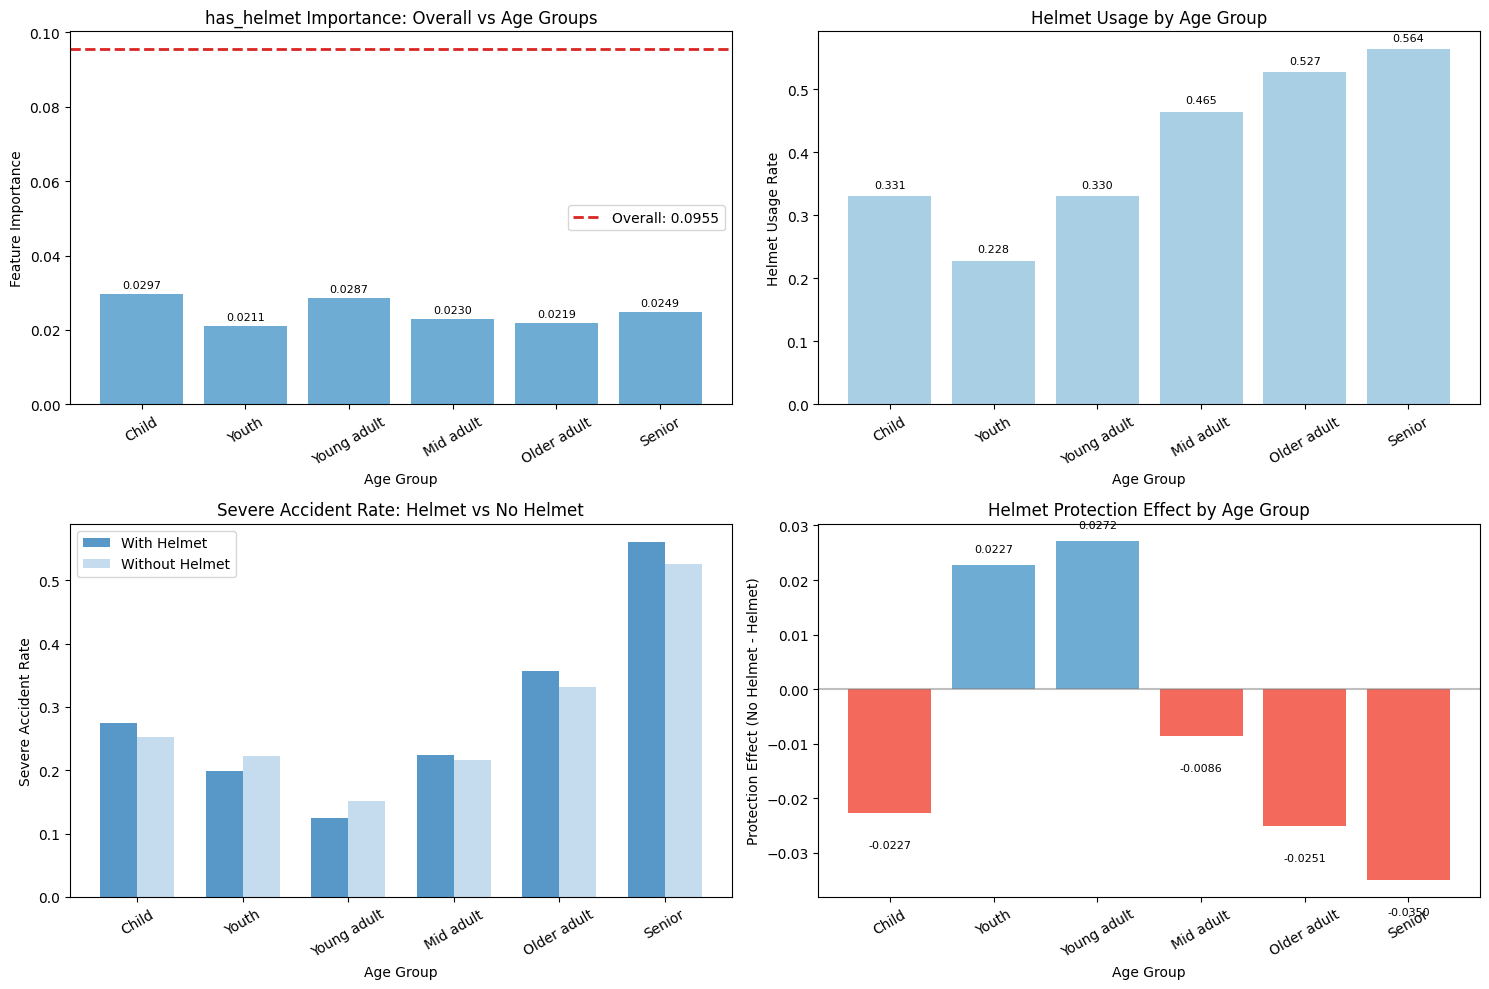

In [37]:

age_labels = {
    -1: 'Invalid',
     0: 'Child',
     1: 'Youth',
     2: 'Young adult',
     3: 'Mid adult',
     4: 'Older adult',
     5: 'Senior'
}

# Define the desired order (child to senior, then invalid)
desired_order = [0, 1, 2, 3, 4, 5, -1]

# Filter to only include age groups that exist in both datasets
modeled_age_groups = list(imp_df.columns)
available_age_groups = [ag for ag in desired_order if ag in modeled_age_groups]

# Reorder helmet_df to match the desired order
helmet_df_ordered = helmet_df[helmet_df['age_group'].isin(available_age_groups)].copy()
helmet_df_ordered = helmet_df_ordered.set_index('age_group').loc[available_age_groups].reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
x_pos = np.arange(len(available_age_groups))

# 1. Feature importance comparison
ax1 = axes[0, 0]
helmet_importances = [imp_df.loc['has_helmet', grp] for grp in available_age_groups]
overall_importance = feat_imp.loc[feat_imp['feature']=='has_helmet', 'importance'].item()

ax1.bar(x_pos, helmet_importances, alpha=0.8, color=plt.cm.Blues(0.6))
ax1.axhline(overall_importance, color=plt.cm.Reds(0.7), linestyle='--', linewidth=2,
           label=f'Overall: {overall_importance:.4f}')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([age_labels[int(g)] for g in available_age_groups], rotation=30)
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Feature Importance')
ax1.set_title('has_helmet Importance: Overall vs Age Groups')
ax1.legend()
for i, v in enumerate(helmet_importances):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=8)

# 2. Helmet usage rates
ax2 = axes[0, 1]
helmet_rates = helmet_df_ordered['helmet_rate'].values

ax2.bar(x_pos, helmet_rates, alpha=0.8, color=plt.cm.Blues(0.4))
ax2.set_xticks(x_pos)
ax2.set_xticklabels([age_labels[int(g)] for g in available_age_groups], rotation=30)
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Helmet Usage Rate')
ax2.set_title('Helmet Usage by Age Group')
for i, v in enumerate(helmet_rates):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Severity rates: helmet vs no helmet
ax3 = axes[1, 0]
width = 0.35
helmet_severe = helmet_df_ordered['severe_with_helmet'].values
no_helmet_severe = helmet_df_ordered['severe_without_helmet'].values

ax3.bar(x_pos - width/2, helmet_severe, width, label='With Helmet', color=plt.cm.Blues(0.7), alpha=0.8)
ax3.bar(x_pos + width/2, no_helmet_severe, width, label='Without Helmet', color=plt.cm.Blues(0.3), alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([age_labels[int(g)] for g in available_age_groups], rotation=30)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Severe Accident Rate')
ax3.set_title('Severe Accident Rate: Helmet vs No Helmet')
ax3.legend()

# 4. Protection effect
ax4 = axes[1, 1]
protection_effect = helmet_df_ordered['helmet_protection'].values
colors = [plt.cm.Blues(0.6) if v > 0 else plt.cm.Reds(0.6) for v in protection_effect if not np.isnan(v)]

# Handle NaN values
valid_mask = ~np.isnan(protection_effect)
valid_effects = protection_effect[valid_mask]
valid_x_pos = x_pos[valid_mask]
valid_age_groups = [available_age_groups[i] for i in range(len(available_age_groups)) if valid_mask[i]]

ax4.bar(valid_x_pos, valid_effects, color=colors, alpha=0.8)
ax4.axhline(0, color='gray', linestyle='-', alpha=0.5)
ax4.set_xticks(valid_x_pos)
ax4.set_xticklabels([age_labels[int(g)] for g in valid_age_groups], rotation=30)
ax4.set_xlabel('Age Group')
ax4.set_ylabel('Protection Effect (No Helmet - Helmet)')
ax4.set_title('Helmet Protection Effect by Age Group')

for i, (pos, v) in enumerate(zip(valid_x_pos, valid_effects)):
    offset = 0.002 if v > 0 else -0.005
    va = 'bottom' if v > 0 else 'top'
    ax4.text(pos, v + offset, f'{v:.4f}', ha='center', va=va, fontsize=8)

plt.tight_layout()
plt.show()